**RNN과 CNN을 사용해 시퀀스 처리하기**

# 설정

먼저 몇 개의 모듈을 임포트한다. 맷플롯립 그림을 저장하는 함수를 준비한다.

In [1]:
# 공통 모듈 임포트
import sys
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt

# 코랩에서 실행되는 노트북인가?
IS_COLAB = 'google.colab' in sys.modules

if not tf.config.list_physical_devices('GPU'):
    print('감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.')
    if IS_COLAB:
        print('런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.')

# 깔끔한 그래프 출력을 위해
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = '.'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images')
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, f'{fig_id}.{fig_extension}')
    print(f'그림 저장 {fig_id}')
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 기본적인 RNN

## 데이터셋 생성

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  # 웨이브 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))  # + 웨이브 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)  # + 잡음
    return series[..., np.newaxis].astype(np.float32)

In [3]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, n_steps]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, n_steps]
X_test, y_test = series[9000:, :n_steps], series[9000:, n_steps]

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

그림 저장 time_series_plot


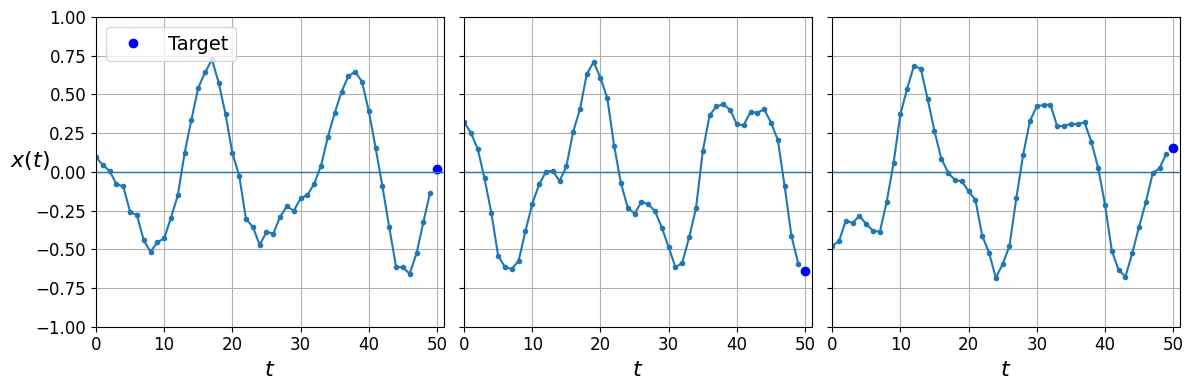

In [5]:
def plot_series(series, y=None, y_pred=None, x_label='$t$', y_label='$x(t)$', legend=True):
    plt.plot(series, '.-')
    if y is not None:
        plt.plot(n_steps, y, 'bo', label='Target')
    if y_pred is not None:
        plt.plot(n_steps, y_pred, 'rx', markersize=10, label='Prediction')
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc='upper left')


fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0], y_label=('$x(t)$' if col == 0 else None), legend=(col == 0))
save_fig('time_series_plot')
plt.show()

**노트**: 이 노트북에서 파란 점은 타깃을 나타내고 빨강 X 표시는 예측을 나타낸다.

## 기준 성능 계산하기

단순한 예측 (마지막 관측값을 사용해 예측한다):

In [6]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.02133047

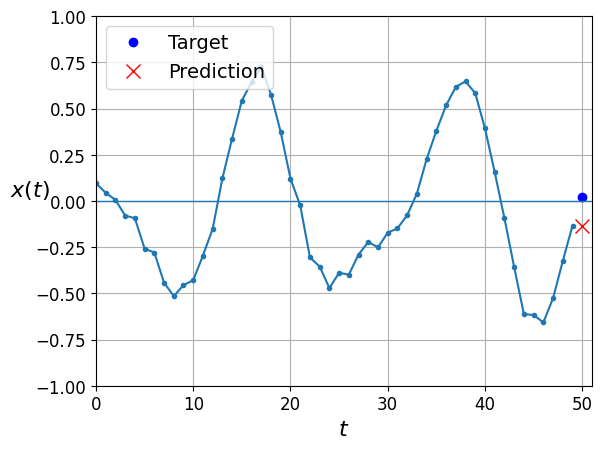

In [7]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

선형 예측:

In [8]:
model = keras.models.Sequential([keras.layers.Flatten(input_shape=[50, 1]), keras.layers.Dense(1)])
model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 2s 3ms/step - loss: 0.0767 - val_loss: 0.0333
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0246 - val_loss: 0.0187
Epoch 3/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0154 - val_loss: 0.0127
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0118 - val_loss: 0.0103
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0100 - val_loss: 0.0087
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0089 - val_loss: 0.0078
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0079 - val_loss: 0.0072
Epoch 8/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0073 - val_loss: 0.0065
Epoch 9/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0066 - val_loss: 0.0059
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0062 - val_loss: 0.0057

In [9]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 1ms/step - loss: 0.0039


0.0039182500913739204

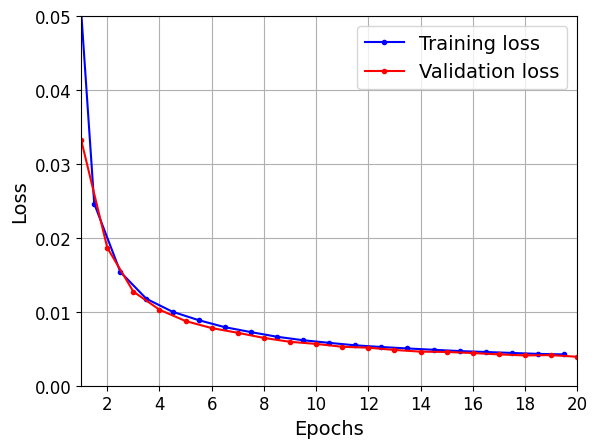

In [10]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, 'b.-', label='Training loss')
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, 'r.-', label='Validation loss')
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)


plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

63/63 [==============================] - 0s 920us/step


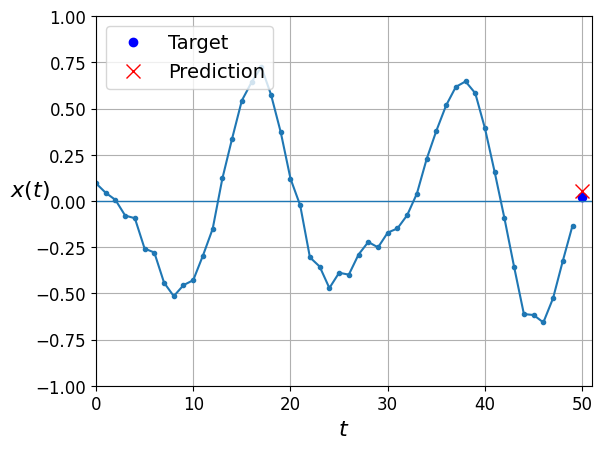

In [11]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## 간단한 RNN 사용하기

In [12]:
model = keras.models.Sequential([keras.layers.SimpleRNN(1, input_shape=[None, 1])])
optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss='mse', optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 12s 54ms/step - loss: 0.1232 - val_loss: 0.0328
Epoch 2/20
219/219 [==============================] - 11s 50ms/step - loss: 0.0275 - val_loss: 0.0243
Epoch 3/20
219/219 [==============================] - 12s 53ms/step - loss: 0.0210 - val_loss: 0.0195
Epoch 4/20
219/219 [==============================] - 11s 49ms/step - loss: 0.0173 - val_loss: 0.0166
Epoch 5/20
219/219 [==============================] - 11s 50ms/step - loss: 0.0149 - val_loss: 0.0147
Epoch 6/20
219/219 [==============================] - 11s 49ms/step - loss: 0.0134 - val_loss: 0.0135
Epoch 7/20
219/219 [==============================] - 11s 51ms/step - loss: 0.0124 - val_loss: 0.0127
Epoch 8/20
219/219 [==============================] - 11s 49ms/step - loss: 0.0119 - val_loss: 0.0123
Epoch 9/20
219/219 [==============================] - 11s 51ms/step - loss: 0.0115 - val_loss: 0.0120
Epoch 10/20
219/219 [==============================] - 11s 51ms/step - loss: 0.011

In [13]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 10ms/step - loss: 0.0119


0.011876137927174568

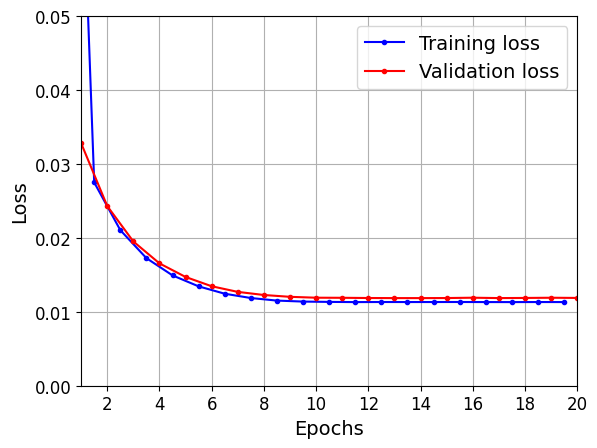

In [14]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

63/63 [==============================] - 1s 9ms/step


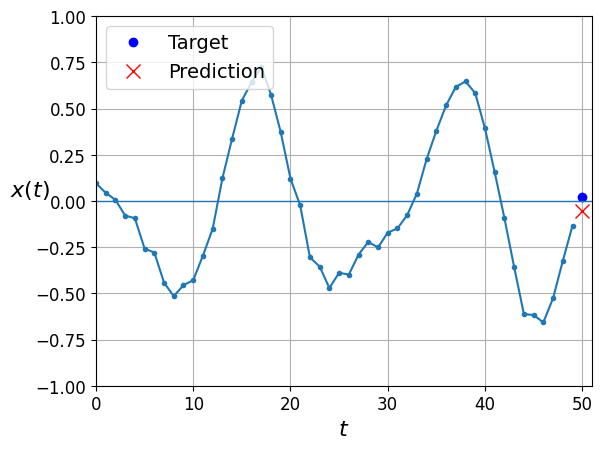

In [15]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## 심층 RNN

In [16]:
model = keras.models.Sequential(
    [
        keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.SimpleRNN(20, return_sequences=True),
        keras.layers.SimpleRNN(1)
    ]
)
model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 43s 190ms/step - loss: 0.0145 - val_loss: 0.0042
Epoch 2/20
219/219 [==============================] - 43s 195ms/step - loss: 0.0035 - val_loss: 0.0041
Epoch 3/20
219/219 [==============================] - 38s 173ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 4/20
219/219 [==============================] - 39s 177ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 5/20
219/219 [==============================] - 44s 203ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 6/20
219/219 [==============================] - 39s 180ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 41s 188ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 8/20
219/219 [==============================] - 43s 198ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 47s 214ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 10/20
219/219 [==============================] - 42s 194ms/step - l

In [17]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 2s 30ms/step - loss: 0.0027


0.002660999307408929

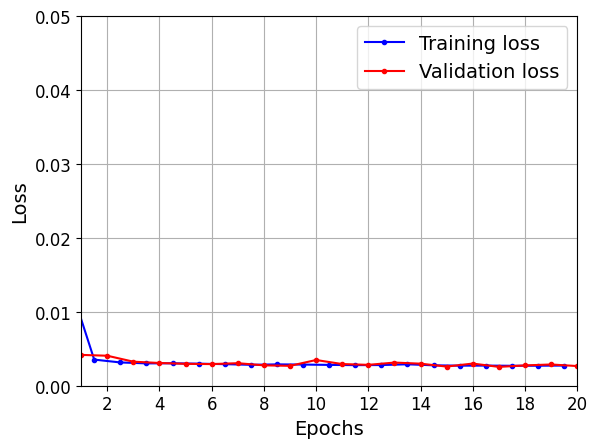

In [18]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

63/63 [==============================] - 2s 29ms/step


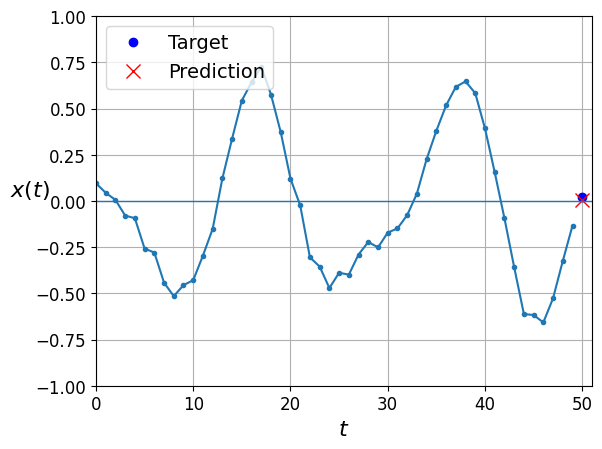

In [19]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

두 번째 `SimpleRNN` 층은 마지막 출력만 반환한다:

In [20]:
model = keras.models.Sequential(
    [
        keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.SimpleRNN(20),
        keras.layers.Dense(1)
    ]
)
model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 29s 126ms/step - loss: 0.0115 - val_loss: 0.0038
Epoch 2/20
219/219 [==============================] - 29s 132ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 3/20
219/219 [==============================] - 29s 133ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 4/20
219/219 [==============================] - 28s 127ms/step - loss: 0.0032 - val_loss: 0.0035
Epoch 5/20
219/219 [==============================] - 29s 131ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 6/20
219/219 [==============================] - 28s 129ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 28s 128ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 8/20
219/219 [==============================] - 27s 124ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 9/20
219/219 [==============================] - 28s 128ms/step - loss: 0.0029 - val_loss: 0.0033
Epoch 10/20
219/219 [==============================] - 27s 123ms/step - l

In [21]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 20ms/step - loss: 0.0028


0.0028113131411373615

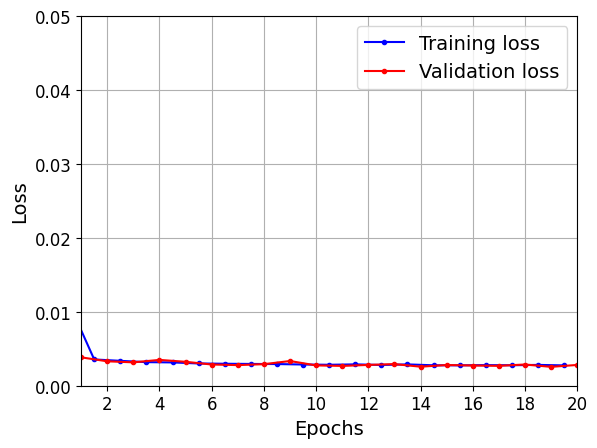

In [22]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

63/63 [==============================] - 1s 19ms/step


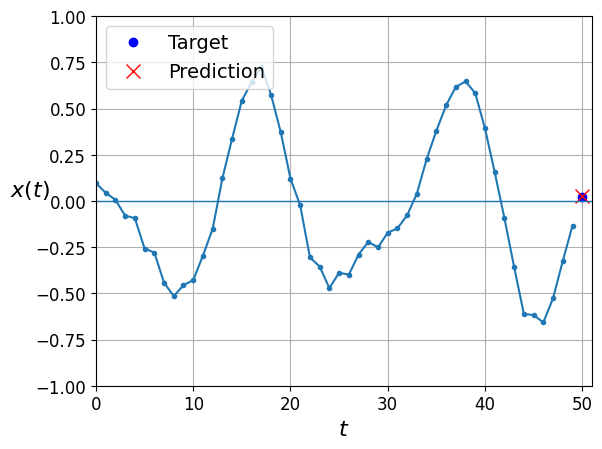

In [23]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## 여러 타임 스텝 앞을 예측하기

In [54]:
series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[np.newaxis]
    X = np.concatenate([X, y_pred_one], axis=1)
Y_pred = X[:, n_steps:]

1/1 [==============================] - 0s 43ms/step


In [55]:
Y_pred.shape

(1, 10, 1)

그림 저장 forecast_ahead_plot


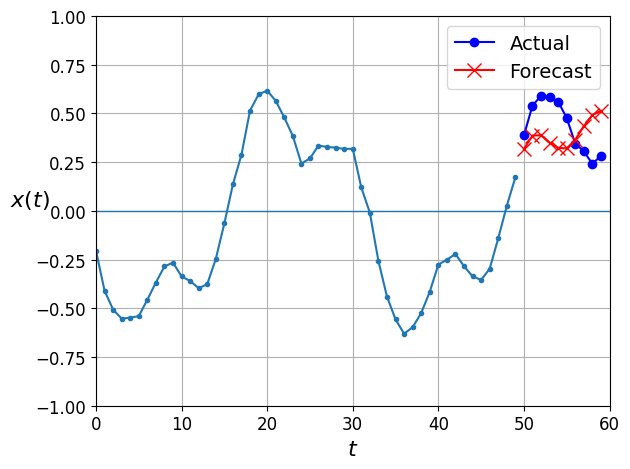

In [62]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], 'bo-', label='Actual')
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], 'rx-', label='Forecast', markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)


plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig('forecast_ahead_plot')
plt.show()

이 모델을 사용해 다음 10개의 값을 예측해 보겠다. 먼저 아홉 개의 타임 스텝을 더 가진 시퀀스를 다시 생성해야 한다.

In [77]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, n_steps:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, n_steps:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, n_steps:, 0]

이제 하나씩 다음 10개의 값을 예측한다:

In [84]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis]
    X = np.concatenate([X, y_pred_one], axis=1)
Y_pred = X[:, n_steps:, 0]

63/63 [==============================] - 1s 21ms/step


In [87]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.020507032

이 성능을 단순한 예측이나 간단한 선형 모델과 비교해 본다:

In [88]:
Y_naive_pred = np.tile(X_valid[:, -1], 10)  # 마지막 타임 스텝 값을 선택해 10번 반복한다
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.2610975